In [45]:

import base64
import requests
import json

CLIENT_ID = '9e4a6ae177824d17b3c9e87fcc3df72a'
CLIENT_SECRET = 'ec500bc9877b47d89409d4f4cbcb8694'
callback='http://google.com/callback/'

def get_token():
    auth_string=CLIENT_ID+":"+CLIENT_SECRET
    auth_bytes=auth_string.encode('utf-8')
    auth_base64=str(base64.b64encode(auth_bytes),'utf-8')

    url="https://accounts.spotify.com/api/token"
    headers={
        'Authorization': 'Basic '+ auth_base64,
        'Content-Type': 'application/x-www-form-urlencoded'
    }

    data={
        'grant_type': 'client_credentials'
    }

    response=requests.post(url,headers=headers,data=data)
    response_json=json.loads(response.content)
    access_token=response_json["access_token"]

    
    return access_token



def get_auth_header(token):
    return {"Authorization": "Bearer "+ token}


token=get_token()
print(token)

BQCHE6xzxq3P7XHXHorslhCYFk9WjKUvlz7I-RqIzXTLRddFjOIeQBgEbKUFRnnYGNnGIzjMv59-JsTAth7AVK24k54snhVGGz7v9T_ddT9QtE1Yb_M


In [46]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials,SpotifyOAuth
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

True

In [47]:
client_id=os.environ.get('CLIENT_ID')
client_secret=os.environ.get('CLIENT_SECRET')
redirect_uri="http://localhost"
token_info='BQD8KvXyMSTcq5QOTDvjEtHU-tirEY6yWY4iH4Ujg_sAz-KC24_Bz9vk74GUJFVz_f0DKX6OqSApJi5S04KpNPVf-XKSkhA4fvjVG4ecsGvdKE_T1Kk'
headers = {
    "Authorization": f"Bearer {token_info}"
}

In [48]:
scope ="user-library-read user-read-playback-state user-modify-playback-state"

client_cred_manager=SpotifyClientCredentials(client_id=client_id,client_secret=client_secret)
sp=spotipy.Spotify(client_credentials_manager=client_cred_manager,auth_manager=SpotifyOAuth(client_id=client_id,client_secret=client_secret,redirect_uri=redirect_uri,scope=scope),requests_timeout=10)

In [19]:
import asyncio
import aiohttp
import nest_asyncio
from aiohttp import ClientSession
nest_asyncio.apply()


async def fetch_preview_url(session, track_id):
    url = f"https://api.spotify.com/v1/tracks/{track_id}"
    async with session.get(url, headers=headers) as response:
        if response.status == 200:
            data = await response.json()
            print(data)
            return data.get('preview_url')
        else:
            print(f"Error fetching track {track_id}: {response.status}")
            return None

async def fetch_all_preview_urls(track_ids):
    async with ClientSession() as session:
        tasks = [fetch_preview_url(session, track_id) for track_id in track_ids]
        return await asyncio.gather(*tasks)

def get_preview_urls(track_ids):
    return asyncio.run(fetch_all_preview_urls(track_ids))

track_ids =  ['5Xak5fmy089t0FYmh3VJiY'] # Replace with actual track IDs
preview_urls = get_preview_urls(track_ids)

for track_id, preview_url in zip(track_ids, preview_urls):
    if preview_url:
        print(f"Track ID: {track_id}, Preview URL: {preview_url}")
    else:
        print(f"Track ID: {track_id}, Preview URL not found")

Error fetching track 5Xak5fmy089t0FYmh3VJiY: 429
Track ID: 5Xak5fmy089t0FYmh3VJiY, Preview URL not found


In [4]:
results = sp.current_user_saved_tracks()
for idx, item in enumerate(results['items']):
    track = item['track']
    print(idx, track['artists'][0]['name'], " – ", track['name'], track['id'],track['preview_url'])

0 Flyleaf  –  All Around Me 5bHwCxqs3jhxjDeztcHFpd None
1 Mindchatter  –  Dopamine Detox 1L1EKS4V4fXLuXfOduyZ9t https://p.scdn.co/mp3-preview/651fad7dada4ed50e48c75351f0d129d9f6b3832?cid=9e4a6ae177824d17b3c9e87fcc3df72a
2 Luciano  –  SUVs 01I8aPBUJIMzCtHsCVvmq5 None
3 Kenny Wayne Shepherd  –  Nothing But The Night 2sF93cCZuKgRLfWF6dNtfE None
4 Spada  –  Be Strong 1PI6MPyMGeRLbKDCaQ3BDi https://p.scdn.co/mp3-preview/2f2d9f5598d15b52c80e98d3052fd3cb780d7c1c?cid=9e4a6ae177824d17b3c9e87fcc3df72a
5 Monophase (IT)  –  Poltergeist 4sQM3sPNTDLDEla3F0UhKf https://p.scdn.co/mp3-preview/e8b8553fdaecd7085f628b52025836dfb8eb2741?cid=9e4a6ae177824d17b3c9e87fcc3df72a
6 Johnny Goth  –  MIDNIGHT 6i1eYbNsiH2wJyfy0LfzdF https://p.scdn.co/mp3-preview/617d2de7fcba8e1f6a4af2bf56a8851aea9e9f14?cid=9e4a6ae177824d17b3c9e87fcc3df72a
7 Arutani  –  Darkness Is My Nickname 0eqTIooSEpK5Z8ALs11qfY https://p.scdn.co/mp3-preview/d22196252be90cc356ed36bc4cbc41d6b86b5320?cid=9e4a6ae177824d17b3c9e87fcc3df72a
8 Thirty Sec

In [4]:
import time

def get_song_embedding(track_id,retries=5):
    try:

        features = sp.audio_features(track_id)
        if features:
            audio_features = features[0]
            #print(audio_features)
            embedding = [
                audio_features['danceability'],
                audio_features['energy'],
                audio_features['loudness'],
                audio_features['speechiness'],
                audio_features['acousticness'],
                audio_features['instrumentalness'],
                audio_features['liveness'],
                audio_features['valence'],
                audio_features['tempo']
            ]
            return np.array(embedding)
    except spotipy.SpotifyException as e:
        if e.http_status == 429:
            if retries > 0:
                retry_after = int(e.headers.get("Retry-After", 5))  # Get the Retry-After header
                print(f"Rate limit exceeded. Retrying in {retry_after} seconds...")
                time.sleep(retry_after)
                return get_song_embedding(track_id,retries-1)
            else:
                print("Max retries reached. Exiting.")
                return None
        else:
            raise e 

In [50]:
my_songs_preview_url={}

In [51]:
results = sp.current_user_saved_tracks()
track_id_to_name={}
new_song_embedding=[]
results = sp.current_user_saved_tracks(limit=50)
total_songs = results['total']
offset = 0
#print("User's Saved Tracks:")
while results:
    
    for i, item in enumerate(results['items']):
        track = item['track']
        track_id_to_name[track['id']] = track['name']
        #my_songs_preview_url[track['name']] = track['preview_url']
        # Add your logic to get song embeddings here
        #new_song_embedding.append(get_song_embedding(track_id=track['id']))
    offset += len(results['items'])
    if len(results['items']) == 0 or offset >= total_songs:
        break
        #new_song_embedding.append(get_song_embedding(track_id=track['id']))
        #print(f"{track['name']} by {track['artists'][0]['name']} and {track['id']}")
    results = sp.current_user_saved_tracks(limit=50, offset=offset)


In [52]:
track_id_to_name.keys()

dict_keys(['5bHwCxqs3jhxjDeztcHFpd', '1L1EKS4V4fXLuXfOduyZ9t', '01I8aPBUJIMzCtHsCVvmq5', '2sF93cCZuKgRLfWF6dNtfE', '1PI6MPyMGeRLbKDCaQ3BDi', '4sQM3sPNTDLDEla3F0UhKf', '6i1eYbNsiH2wJyfy0LfzdF', '0eqTIooSEpK5Z8ALs11qfY', '5paiRbbk5LLoxTDhQAEHrv', '27mFsmEWiSablfQTyZZhgp', '5s2SwtdRPuyOOp7qhTuOev', '36Qe0l5Qc1RelAxbaRjrXP', '6enELEFBmbFdCuS2cxrS8G', '5Ov7KyZfodsafPIn0hgGWT', '7pilE4NULuXBPHZNzODH5i', '6TfBA04WJ3X1d1wXhaCFVT', '5Nu0bLCoyABg5UnNLYog1i', '5Xak5fmy089t0FYmh3VJiY', '5whx37uKlUTuPSUF3Apa92', '0IiNvczlDfLXvSkwjFtOqA', '2ugvsBcowCEaAuGEMEmEgQ', '1aDD3AfN7X1RkfOEJwHDu1', '2cue4DdCwO7himRLESpWk5', '7x8pIrhMu9FCmqqHNyuH0P', '5RQJcwYMP0NEynpd98vrkV', '26XUAwGZqQEyy8Ubhtj4kq', '3hBis5N37g0Qteb3QkjHX0', '4uSQVpXa7XJuFBwbPaK4xV', '5rqQv5jUcg58xsi1nuZDl9', '1FoCSrNyUVF00C8foohH2G', '17s9ohMleXceK8Qobgl8Zd', '4LHJmwqTJmECv7Z2tpY7V9', '0xhHw3EIyZ05mboRXpJWxs', '4qUtC2BwFC154Ha8YQRrkk', '7udjTmsTZqdB1xLOHGJ8dM', '1zZYs3FayVtN8pG2jApXLw', '1CjPeV76ysALniw6RD0FQI', '1QWj9NYh8ZcSugtyBhSIea', '

In [19]:
import pickle
with open('my_songs_preview_url.pkl', 'wb') as file:
    pickle.dump(my_songs_preview_url, file)

In [10]:
track_id_by_name = {track_name: index for index, track_name in track_id_to_name.items()}

In [69]:
track_name_by_index = {index: track_name for index, track_name in enumerate(track_id_to_name.values())}

track_name_by_index.values()


dict_values(['All Around Me', 'Dopamine Detox', 'SUVs', 'Nothing But The Night', 'Be Strong', 'Poltergeist', 'MIDNIGHT', 'Darkness Is My Nickname', 'Pyres Of Varanasi', 'DO YOU DOUBT ME TRAITOR', 'Holloko - Afro Groove Mix', 'Everything I Wanted', 'Coming Back', 'When My Train Pulls In', 'Not Nice At All', "You're Gonna Go Far, Kid", 'Take Away My Pain', 'Black', 'The Answer Lies Within', 'Light In the Sky', 'Time Goes By', 'Feliteira', "Tell Me It's Over (feat. Summer Walker & 6LACK)", 'cellophane', 'Mumble Rapper vs. Lyricist', "Feelin' Myself", 'My Guy - Single Version', 'Like U', 'Falling Asleep At The Wheel', 'Green Eyes', 'striptease', 'Whispers, Pt. 1', 'Body', 'How to disappear', 'Bel Mercy', 'Devastación', 'Ratenplan', 'Concorde', 'Are You All Good?', "Don't Play", 'Codeine', 'Veridis Quo', 'On My Knees - Cassian Remix', 'The Sign', 'Anchor Point', 'PUT YOU ON GAME', 'En Su Lugar', 'Kuar - FNX Omar Remix', 'Boeing 747 - D-Formation Remix', 'Tataki', 'Baby', 'Fiction (Break Bad

In [71]:
track_name_by_index.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [13]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
# Assuming you have saved the scaler used during training
scaler = MinMaxScaler()
new_scaled_array = scaler.fit_transform(new_song_embedding)

In [15]:
import pickle
with open('my_spotify_song_scaled_embeddings.pkl', 'wb') as file:
    pickle.dump(new_scaled_array, file)

In [59]:
features=['danceability', 'energy', \
       'loudness', 'speechiness', \
        'acousticness', 'instrumentalness', \
       'liveness', 'valence', 'tempo',]
new_scaled_array=np.load('my_spotify_song_scaled_embeddings.pkl', allow_pickle=True)
new_scaled_dataframe=pd.DataFrame(new_scaled_array, columns=features)

new_scaled_dataframe

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.400943,0.892226,0.837612,0.053042,0.025310,0.000000,0.024566,0.501908,0.590871
1,0.771226,0.684812,0.766826,0.033650,0.530645,0.302181,0.089420,0.588809,0.521435
2,0.807783,0.267950,0.715741,0.600760,0.328632,0.000000,0.071733,0.635439,0.542634
3,0.658019,0.766151,0.801820,0.015779,0.164810,0.002773,0.101430,0.905680,0.341298
4,0.553066,0.917644,0.782248,0.018821,0.027823,0.438214,0.403865,0.296312,0.410879
...,...,...,...,...,...,...,...,...,...
606,0.484670,0.045387,0.523467,0.026236,0.871355,0.001121,0.100338,0.195634,0.567019
607,0.622642,0.825121,0.846999,0.060646,0.230138,0.006781,0.205153,0.702204,0.320724
608,0.834906,0.724465,0.841731,0.092586,0.011039,0.000000,0.039852,0.337643,0.320432
609,0.639151,0.981699,0.791315,0.086122,0.002627,0.938733,0.093788,0.171259,0.445021


In [82]:
new_df = pd.DataFrame(list(track_id_to_name.items()), columns=['track_id', 'track_name'])
new_scaled_dataframe.reset_index(drop=True, inplace=True)
new_df.reset_index(drop=True, inplace=True)
df3 = pd.concat([new_scaled_dataframe, new_df], axis=1)
df3.insert(0, 'SongIndex', range(0, len(df3)))
df3.to_csv('test_set_data_scaled.csv')

In [109]:
df3

,SongIndex,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_id,track_name
0,0,0.400943,0.892226,0.837612,0.053042,0.025310,0.000000,0.024566,0.501908,0.590871,5bHwCxqs3jhxjDeztcHFpd,All Around Me
1,1,0.771226,0.684812,0.766826,0.033650,0.530645,0.302181,0.089420,0.588809,0.521435,1L1EKS4V4fXLuXfOduyZ9t,Dopamine Detox
2,2,0.807783,0.267950,0.715741,0.600760,0.328632,0.000000,0.071733,0.635439,0.542634,01I8aPBUJIMzCtHsCVvmq5,SUVs
3,3,0.658019,0.766151,0.801820,0.015779,0.164810,0.002773,0.101430,0.905680,0.341298,2sF93cCZuKgRLfWF6dNtfE,Nothing But The Night
4,4,0.553066,0.917644,0.782248,0.018821,0.027823,0.438214,0.403865,0.296312,0.410879,1PI6MPyMGeRLbKDCaQ3BDi,Be Strong
...,...,...,...,...,...,...,...,...,...,...,...,...
606,606,0.484670,0.045387,0.523467,0.026236,0.871355,0.001121,0.100338,0.195634,0.567019,4q8PA5nJG8fdbMdJMlPNdK,Winter Birds
607,607,0.622642,0.825121,0.846999,0.060646,0.230138,0.006781,0.205153,0.702204,0.320724,3MjrueDQKVr6xDDseZwhEd,Figure It Out
608,608,0.834906,0.724465,0.841731,0.092586,0.011039,0.000000,0.039852,0.337643,0.320432,7MAczr62s9rHXsd0vPxkYX,Nu Nu Nu
609,609,0.639151,0.981699,0.791315,0.086122,0.002627,0.938733,0.093788,0.171259,0.445021,34JOISepIqZW6pNdmgUybW,Substance Abuse


In [55]:
class Autoencoder(nn.Module):
    def __init__(self,input_dim,encoding_dim):
        super(Autoencoder,self).__init__()
        self.encoder=nn.Sequential(
            nn.Linear(input_dim,encoding_dim),
            nn.ReLU()
        )
        self.decoder=nn.Sequential(
            nn.Linear(encoding_dim,input_dim),
            nn.Sigmoid()
        )
    def forward(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return encoded,decoded

# Load the model
input_dim = new_scaled_array.shape[1]# Your input dimension
encoding_dim = 6# Your encoding dimension
model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
model.load_state_dict(torch.load('spotify_dict_DL_model.pth'))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=9, out_features=6, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=9, bias=True)
    (1): Sigmoid()
  )
)

In [60]:
new_songs_features_tensor = torch.tensor(new_scaled_array, dtype=torch.float32)
with torch.no_grad():
    new_song_embeddings = model.encoder(new_songs_features_tensor).numpy()
#print(new_song_embedding.shape)

In [61]:
new_song_embeddings.shape

(611, 6)

In [62]:
np.save('test_song_embeddings.npy', new_song_embeddings)

In [63]:

original_song_feature_=np.load('training_song_embeddings.npy')
my_song_feature_=np.load('test_song_embeddings.npy')

In [64]:
print(original_song_feature_.shape)
print(my_song_feature_.shape)

(114000, 6)
(611, 6)


In [104]:
my_song_feat=pd.read_csv('test_set_data_scaled.csv')
train_song_feat=pd.read_csv('training_set_data_scaled.csv')

features=['danceability', 'energy', \
       'loudness', 'speechiness', \
        'acousticness', 'instrumentalness', \
       'liveness', 'valence', 'tempo']


my_song_feature_array= my_song_feat[features].values

train_song_feature_array= train_song_feat[features].values

In [112]:
train_song_feature_array

(114000, 9)

In [113]:
my_song_feature_array_dict=dict(zip(track_id_to_name.values(), my_song_feature_array))
import pickle
with open('my_song_feature_array_dict.pkl', 'wb') as file:
    pickle.dump(my_song_feature_array_dict, file)


my_song_feature_array_dict['Darkness Is My Nickname']

array([0.78773585, 0.57907152, 0.68569604, 0.11958175, 0.00940056,
       0.91692627, 0.08068566, 0.08117847, 0.29284534])

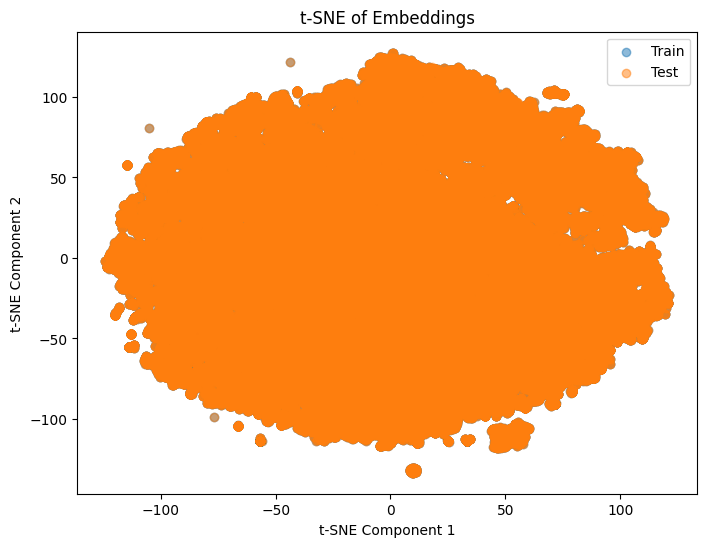

In [88]:


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


combined_embeddings = np.vstack((train_song_feature_array, my_song_feature_array))

from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(combined_embeddings)

# Split back into train and test
tsne_train = tsne_result[:train_song_feature_array.shape[0]]
tsne_test = tsne_result[my_song_feature_array.shape[0]:]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(tsne_train[:, 0], tsne_train[:, 1], alpha=0.5, label='Train')
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], alpha=0.5, label='Test')
plt.legend()
plt.title('t-SNE of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [99]:
import pandas as pd
df=pd.read_csv('songs_with_clusters.csv')
df.head(10)

song_index_to_name = df['track_name'].to_dict()

trackName_to_trackID = df.set_index('track_name')['track_id'].to_dict()
trackID_to_trackName = df.set_index('track_id')['track_name'].to_dict()



In [106]:
train_song_feature_array_dict=dict(zip(trackID_to_trackName.values(), train_song_feature_array))

In [107]:
with open('train_song_feature_array_dict.pkl', 'wb') as file:
    pickle.dump(train_song_feature_array_dict, file)

In [26]:
len(trackName_to_trackID.values())

73609

In [40]:
len(trackID_to_trackName)

73609

In [32]:
similarities = cosine_similarity(new_song_embeddings, original_song_feature_)

track_to_recommendation = {}
num_recommendations = 5
recommended_songsID_set = set()
recommended_songs_set = set()

for i, seed_embedding in enumerate(new_song_embeddings):
    if i < similarities.shape[0]:  # Ensure the index is within bounds
        similar_indices = np.argsort(similarities[i])[::-1]
        recommend_list = []
        for idx in similar_indices:
            song_name = song_index_to_name[idx] #from Original Track set
            if song_name not in recommended_songs_set:
                recommend_list.append(song_name)
                recommended_songsID_set.add(trackName_to_trackID[song_name])
                recommended_songs_set.add(song_name)
                if len(recommend_list) == num_recommendations:
                    break
        #print(i)
        track_to_recommendation[track_name_by_index[i]] = recommend_list
        

# # Display the recommendations
# for track, recommendations in track_to_recommendation.items():
#     print(f"\nRecommendations for {track}:")
#     for rec in recommendations:
#         print(f"  {rec}")


In [33]:
import pickle 

with open('track_to_recommendation.pkl', 'wb') as file:
    pickle.dump(track_to_recommendation, file)



In [114]:
import pickle
track_to_recommendation=pickle.load(open('track_to_recommendation.pkl', 'rb'))

In [116]:
recommendations=track_to_recommendation['Darkness Is My Nickname']
recommended_song_features = [train_song_feature_array_dict[rec] for rec in recommendations]

In [121]:
recommended_songs_df=pd.DataFrame(recommended_song_features,columns=features)
recommended_songs_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.765482,0.452,0.807003,0.033782,0.554217,0.000000,0.0608,0.768844,0.369907
1,0.810152,0.677,0.777519,0.373057,0.405622,0.000000,0.1510,0.695477,0.415500
2,0.616244,0.578,0.762314,0.026839,0.167671,0.000702,0.1420,0.617085,0.627094
3,0.688325,0.522,0.770397,0.033472,0.700803,0.000086,0.1020,0.716583,0.598836
4,0.450761,0.873,0.777001,0.331606,0.027410,0.000154,0.2980,0.149749,0.363842


In [70]:
playlist_id = '05fiNclFkxsCiz3TkqbTdo'
results = sp.playlist_tracks(playlist_id)
tracks = results['items']
for track in tracks:
    print(track['track']['id'])

5Ov7KyZfodsafPIn0hgGWT
1BQkVDlEOtYKOaotnJuNzz
6enELEFBmbFdCuS2cxrS8G
4pjo6uHUuP2FgoBfphagOd
193RPPANAhUa4KZmq35hUc
2sF93cCZuKgRLfWF6dNtfE


In [40]:
import retrying

@retrying.retry(wait_fixed=2000, stop_max_attempt_number=3)
def get_album_art(track_id):
    try:
        track = sp.track(track_id)
        if track and track['album'] and track['album']['images'] and len(track['album']['images']) > 0:
            album_art_url = track['album']['images'][0]['url']
            return album_art_url
        else:
            # Provide a default URL or handle the case where images are not available
            return "default_album_art_url"
    except spotipy.SpotifyException as e:
        print(f"Error getting album art for track ID {track_id}: {e}")
    return None


In [41]:
my_track_to_album_art={}
for track_id in list(track_id_to_name.keys()):
    album_art_url = get_album_art(track_id)
    my_track_to_album_art[track_id_to_name[track_id]]=album_art_url

In [43]:
with open('my_track_to_album_art.pkl', 'wb') as file:
    pickle.dump(my_track_to_album_art, file)

In [46]:
rec_track_to_album_art={}
for track_name in list(track_id_to_name.values()):
    for x in track_to_recommendation[track_name]:
        album_art_url = get_album_art(trackID_to_trackName[x])
        rec_track_to_album_art[x]=album_art_url

In [47]:
with open('rec_track_to_album_art.pkl', 'wb') as file:
    pickle.dump(rec_track_to_album_art, file)

In [8]:
training_songs_preview_url={}


In [14]:
import asyncio
import aiohttp
import nest_asyncio
from aiohttp import ClientSession
nest_asyncio.apply()



async def fetch_preview_url(session, track_id):
    url = f"https://api.spotify.com/v1/tracks/{track_id}"
    async with session.get(url, headers=headers) as response:
        if response.status == 200:
            data = await response.json()
            return data.get('preview_url')
        else:
            print(f"Error fetching track {track_id}: {response.status}")
            return None

async def fetch_all_preview_urls(track_ids):
    async with ClientSession() as session:
        tasks = [fetch_preview_url(session, track_id) for track_id in track_ids]
        return await asyncio.gather(*tasks)

def get_preview_urls(track_ids):
    return asyncio.run(fetch_all_preview_urls(track_ids))

track_ids =  list(trackID_to_trackName.keys()) # Replace with actual track IDs
preview_urls = get_preview_urls(track_ids)

for track_id, preview_url in zip(track_ids, preview_urls):
    if preview_url:
        print(f"Track ID: {track_id}, Preview URL: {preview_url}")
        training_songs_preview_url[trackID_to_trackName[track_id]]=preview_url
    else:
        print(f"Track ID: {track_id}, Preview URL not found")
                

Error fetching track 6lfxq3CG4xtTiEg7opyCyx: 429
Error fetching track 6CgNoAbFJ4Q4Id4EjtbXlC: 429
Error fetching track 6xKeQgzfjixSUld14qUezm: 429
Error fetching track 3S0OXQeoh0w6AY8WQVckRW: 429
Error fetching track 7k9GuJYLp2AzqokyEdwEw2: 429
Error fetching track 4qPNDBW1i3p13qLCt0Ki3A: 429
Error fetching track 0X9MxHR1rTkEHDjp95F2OO: 429
Error fetching track 4ptDJbJl35d7gQfeNteBwp: 429
Error fetching track 0IktbUcnAGrvD03AWnz3Q8: 429
Error fetching track 4LbWtBkN82ZRhz9jqzgrb3: 429
Error fetching track 5SuOikwiRyPMVoIQDJUgSV: 429
Error fetching track 4Yo0igmcoNyat1secaH0OD: 429
Error fetching track 6Vc5wAMmXdKIAM7WUoEb7N: 429
Error fetching track 1EzrEOXmMH3G43AXT1y7pA: 429
Error fetching track 5vjLSffimiIP26QG5WcN2K: 429
Error fetching track 5ivF4eQBqJiVL5IAE9jRyl: 429
Error fetching track 210JCw2LbYD4YIs8GiZ9iP: 429
Error fetching track 01MVOl9KtVTNfFiBU9I7dc: 429
Error fetching track 6JGjevTaqr9J1xp7YvYUKF: 429
Error fetching track 7Af2YlwMZryKOQiRfwMsD2: 429
Error fetching track

KeyboardInterrupt: 

In [18]:
len(track_id_chunks)

74220

In [ ]:
with open('song_url.pkl', 'wb') as file:
    pickle.dump(song_url, file)